In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# for interactive plots replace 'inline' with 'widget' and run in standalone jupyter notebook/lab
import os
from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData as SepiaData
import numpy as np
import sepia.SepiaPlot as SepiaPlot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from nedderimp import nedderimp
from scipy.interpolate import interp2d
from copy import deepcopy

def dist2pi(x1,x2):
    # computes the distance assuming periodicity: 2pi=0
    # x1 and x2 are vectors with common length and values
    # between 0 and 2pi
    d = abs(x1-x2)
    iwrap = d > np.pi
    d[iwrap] = 2*np.pi - d[iwrap]
    return(d)
def dnorm(x,mu,scale):  
    # normal density in 1-d. 
    # It is scaled so that the 1-d integral is 1
    # mu and scale are scalars, x is an array...
    out=np.zeros(len(x))
    u=abs(x-mu)/scale
    out = (1.0/(np.sqrt(2*np.pi)*scale)) * np.exp(-.5 * u**2)
    return(out)

In [2]:
# simulation design
design = np.array([
    [0.7714,    0.4286,    0.0286],
    [0.3714,    0.1143,    0.7143],
    [0.1714,    0.4571,    0.8857],
    [0.3429,    0.6000,    0.8000],
    [0.8000,    0.6286,    0.4000],
    [0.7429,    0.5429,         0],
    [0.6571,    1.0000,    0.6286],
    [0.2857,         0,    0.4571],
    [0.5143,    0.9429,    0.2286],
    [0.6857,    0.3143,    0.6571],
    [0.8286,    0.2000,    1.0000],
    [0.9714,    0.3429,    0.6000],
    [0.4000,    0.8000,    0.2000],
    [0.5429,    0.2857,    0.2857],
    [0.9143,    0.8857,    0.2571],
    [0.0571,    0.0286,    0.0857],
    [0.1143,    0.5714,    0.7429],
    [0.2000,    0.2286,    0.3714],
    [0.4571,    0.9143,    0.3429],
    [0.6286,    0.7143,    0.6857],
    [     0,    0.8286,    0.9429],
    [0.8857,    0.0857,    0.9714],
    [0.2286,    0.0571,    0.5714],
    [0.7143,    0.1714,    0.8571],
    [0.2571,    0.4857,    0.1429],
    [0.5714,    0.4000,    0.8286],
    [0.9429,    0.6857,    0.4857],
    [0.4857,    0.1429,    0.1143],
    [1.0000,    0.8571,    0.9143],
    [0.6000,    0.6571,    0.5143],
    [0.1429,    0.7429,    0.5429],
    [0.8571,    0.2571,    0.0571],
    [0.3143,    0.3714,    0.4286],
    [0.4286,    0.7714,    0.7714],
    [0.0286,    0.9714,    0.3143],
    [0.0857,    0.5143,    0.1714]])

# number of experiements and simulations
n = 3; m = design.shape[0]

# these parameter values simulate expt 10 in Neddermeyer '43
# params =             [R1      lam     s         rho   mratio   u0]
params10 = np.array([1.5*2.54, 2/3,  3e5*6.84e4,  7.5,   .32,   1.65e10])
paramslhs = np.zeros((m, 6))
for i in range(m):#
    paramslhs[i,:] = params10*np.array([1, 1, design[i,1]*.2+.9, 1, design[i,0]*.65+.5, design[i,2]*.2+.9])
# the simulation runs will vary mratio from .32*[.5 to 1.15]
#                                s      from s0*[.9 to 1.1]
#                                u0     from u0*[.9 to 1.1]

### A plot of the implosion over time

In [3]:
nt = 22; nphi = 26
time = np.c_[np.linspace(0,5.0e-5,nt,endpoint=True)]
phi = np.linspace(0,1,nphi,endpoint=True) * 2*np.pi;
rinner = nedderimp(time,params10);
lam = params10[1]; R1 = params10[0];
router = np.sqrt(rinner**2 + 1 - lam**2);
xycirc = np.array([np.cos(phi),np.sin(phi)]).T
r = nedderimp(time,params10)

# Generate simulation data

In [4]:
yr = np.zeros((m,nt))
for i in range(m):
    params = paramslhs[i,:]
    yr[i,:] = params[0]*nedderimp(time,params)

y_sim = np.tile(yr,nphi)
# indices
y_sim_ind_time_phi = np.zeros((22*26,2))
y_sim_ind_time_phi[:,0] = np.repeat(time,26)
y_sim_ind_time_phi[:,1] = np.tile(phi,22)
x_sim = design[:,0].reshape(m,1)
t_sim = design[:,1:3]

# Generate observed data

In [5]:
phi_obs = np.arange(0,(2*np.pi-.1),(2*np.pi/16))
n_phi_obs = phi_obs.shape[0]
time_obs = [np.array([1.5e-5, 2.7e-5, 4.5e-5]),np.array([4.5e-5]),np.array([2.5e-5, 4.5e-5])]
n_time_obs = [tmp.shape[0] for tmp in time_obs]

phiknots = np.arange(0,2*np.pi-.1,2*np.pi/8)
dknots = np.expand_dims(np.array([.04, -.03, .03, -.03, .02, -.03, .03, -.03]),1)*2.5
pphiknots = len(phiknots)
Ddelt = np.zeros((phi_obs.shape[0], pphiknots));
datadelt = np.matmul(Ddelt,dknots)

# observations
r_obs = [None]*3; y_obs = [None]*3
for i in range(3):
    obs_params = deepcopy(params10)
    if i==1: obs_params[4]=.17
    elif i==2: obs_params[4]=.36
    r_obs[i] = np.atleast_2d(obs_params[0]*nedderimp(time_obs[i],obs_params))
    y_obs[i] = np.tile(r_obs[i].T,phi_obs.shape[0]).reshape(n_phi_obs,n_time_obs[i]) + np.tile(datadelt,n_time_obs[i])
    y_obs[i] = (y_obs[i] + .01*np.random.normal(size=y_obs[i].shape)).flatten()

# indices of observations
x_obs = ((np.array([params10[4], .17, .36])/.32-.5)/.65).reshape(3,1)
y_ind_obs = [np.column_stack( ( np.concatenate((np.ones(phi_obs.shape[0])*time_obs[0][0],\
                                   np.ones(phi_obs.shape[0])*time_obs[0][1],\
                                       np.ones(phi_obs.shape[0])*time_obs[0][2])), np.tile(phi_obs,3).T ) ),
                np.column_stack( ( (np.ones(phi_obs.shape[0])*time_obs[1]).reshape(16,1), phi_obs.T ) ),
                np.column_stack( ( np.concatenate((np.ones(phi_obs.shape[0])*time_obs[2][0],\
                                   np.ones(phi_obs.shape[0])*time_obs[2][1])), np.tile(phi_obs,2).T ) )]

### Sepia Data

In [6]:
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_sim = y_sim, y_ind_sim = y_sim_ind_time_phi,\
                 x_obs = x_obs, y_obs = y_obs, y_ind_obs = y_ind_obs)
data.transform_xt()

### K basis

In [7]:
# sim
ysimmean = np.mean(y_sim,0)
ysimsd = np.std(y_sim)
ysimStd = (y_sim - np.tile(ysimmean,m).reshape(y_sim.shape))/ysimsd
data.sim_data.orig_y_mean = ysimmean
data.sim_data.orig_y_sd = ysimsd
data.sim_data.y_std = ysimStd
# now represent ye images using eof's
U, s, V = np.linalg.svd(ysimStd.T, full_matrices=False)
numPC = 3
data.sim_data.K = U[:,0:numPC]*s[0:numPC]/np.sqrt(m)
data.sim_data.K = data.sim_data.K.T

# obs
phimat = np.repeat(phi,nt).reshape((nt,nphi),order='F')
timemat = np.repeat(time,nphi).reshape((nt,nphi))
# compute simulator mean values simdat.ymean interpolated to the data values...
interp_func = interp2d(phimat[0,:],timemat[:,0],data.sim_data.orig_y_mean.reshape((nt,nphi),order='F'))
data.obs_data.orig_y_mean = []
data.obs_data.orig_y_sd = []
for k in range(n):
    ymk = interp_func(np.unique(data.obs_data.y_ind[k][:,1]),np.unique(data.obs_data.y_ind[k][:,0]))                                                                             
    data.obs_data.orig_y_mean.append(ymk.flatten())
    data.obs_data.orig_y_sd.append(data.sim_data.orig_y_sd)

# now compute the centered, scaled observed arrival times yStd
data.obs_data.y_std = []
for k in range(n):
    data.obs_data.y_std.append((data.obs_data.y[k] - data.obs_data.orig_y_mean[k])/data.sim_data.orig_y_sd)

data.obs_data.K = []
for k in range(n):
    data.obs_data.K.append(np.zeros((data.obs_data.y_std[k].shape[0], numPC)))
    for j in range(numPC):
        f = interp2d(phimat[0,:],timemat[:,0],np.reshape(data.sim_data.K[j,:],(nt,nphi),order='F'))
        data.obs_data.K[k][:,j] = f(data.obs_data.y_ind[k][:,1],data.obs_data.y_ind[k][:,0])[:,0]

for k in range(n):
    data.obs_data.K[k] = data.obs_data.K[k].T

In [8]:
### D basis

In [9]:
# compute the basis functions for the discrepancy function.
Dsim  = np.zeros((phi.shape[0], pphiknots))
for k in range(pphiknots):
    Ddelt[:,k] = dnorm(dist2pi(phi_obs,phiknots[k]*np.ones(phi_obs.shape[0])),0,np.pi/8).T;
    x = dist2pi(phi,phiknots[k]*np.ones(phi.shape[0])).flatten()
    Dsim[:,k] = dnorm(x=x,mu=0,scale=np.pi/8)

simdelt = np.matmul(Dsim,dknots)
timeknots = np.linspace(0,.5,3)*1e-4
ptimeknots=len(timeknots)
data.obs_data.D = []
for k in range(n):
    knotlocstime = np.reshape(np.repeat(timeknots,pphiknots),(ptimeknots*pphiknots, 1))
    knotlocsphi = np.expand_dims(np.tile(phiknots,ptimeknots),1)
    pv = knotlocstime.shape[0]
    Dobs = np.zeros((data.obs_data.y_std[k].shape[0], pv))
    if k == 0: Dsim = np.zeros((data.sim_data.y_std.shape[1], pv))
    for j in range(pv):
        Dobs[:,j] = dnorm(y_ind_obs[k][:,0],knotlocstime[j],.25*1e-4)*\
            dnorm(dist2pi(y_ind_obs[k][:,1],knotlocsphi[j]*np.ones(y_ind_obs[k][:,1].shape[0])),0,np.pi/8)
        if k == 0:
            Dsim[:,j] = dnorm(timemat.flatten('F'),knotlocstime[j],.25*1e-4)*\
                dnorm(dist2pi(phimat.flatten('F'),knotlocsphi[j]*np.ones(len(phimat.flatten()))),0,np.pi/8)
    if k == 0: data.sim_data.D = Dsim
    data.obs_data.D.append(Dobs.T)
# now normalize Dobs and Dsim so that it gives a var=1 process
dmax = np.amax(np.amax(np.matmul(data.sim_data.D,data.sim_data.D.T)))
for k in range(n):
    data.obs_data.D[k] /= np.sqrt(dmax)
data.sim_data.D /= np.sqrt(dmax)

# Case 1: No optimization, use step size tuning

In [10]:
print(data)
model = setup_model(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 572, obs y dimension ragged
n  =     3 (number of observed data)
m  =    36 (number of simulated data)
p  =     1 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =    24 (transformed discrepancy dimension)



In [11]:
override=0
cachefile_name='neddermeyer_nooptim.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
    model=pickle.load(open(cachefile_name, "rb" ))
else:
    model.tune_step_sizes(50, 20, update_vals=True)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

Step size tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Starting tune_step_sizes...
Default step sizes:
theta
[[0.2 0.2]]
betaV
[[0.1]]
betaU
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]]
lamVz
[[10.]]
lamUz
[[5. 5. 5.]]
lamWs
[[100. 100. 100.]]
lamWOs
[[100.]]
lamOs
[[1255.58364055]]


MCMC sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

Done with tune_step_size.
Selected step sizes:
theta
[[0.14138246 0.15408459]]
betaV
[[0.58409213]]
betaU
[[0.91741277 0.41736129 0.83784957]
 [0.06325774 0.74816371 0.34249399]
 [0.09693799 0.41580707 0.75555416]]
lamVz
[[13847.99134997]]
lamUz
[[1.17608684 0.68736305 1.18831758]]
lamWs
[[4750.92367498 4147.40262238 3688.30336178]]
lamWOs
[[3416.61661513]]
lamOs
[[4155.02989288]]


MCMC sampling: 100%|██████████| 5000/5000 [01:04<00:00, 77.02it/s]


Max effective sample size over thetas: 205
Total samples: 5000


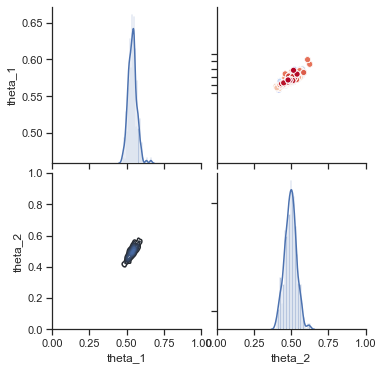

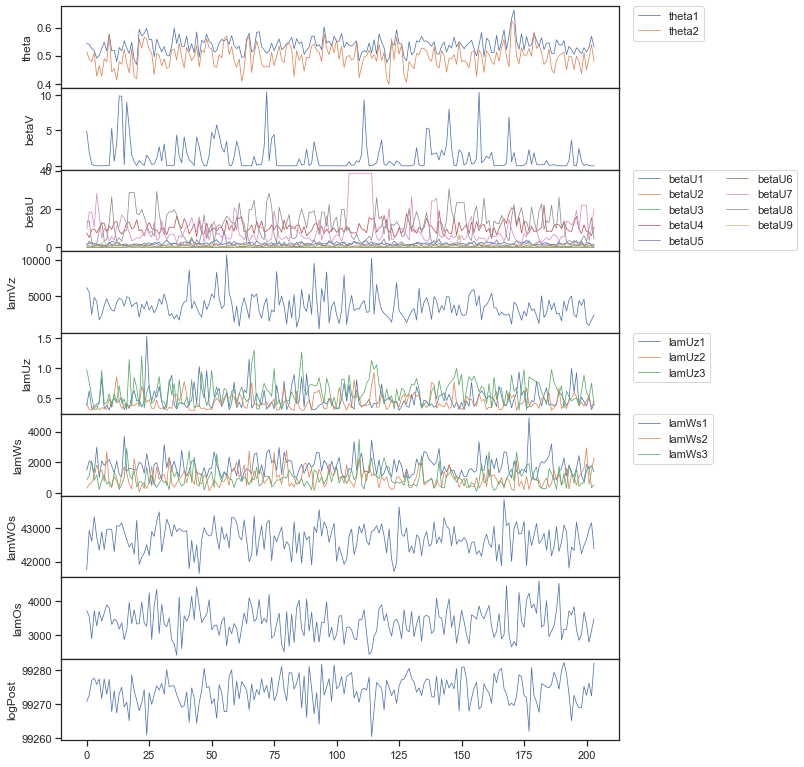

In [12]:
samples_dict = model.get_samples(effectivesamples=True)
SepiaPlot.theta_pairs(samples_dict)
SepiaPlot.mcmc_trace(samples_dict)

# Case 2: Optimization and step size tuning

In [13]:
model2 = setup_model(data)
opt_prm2, history2, p_hist2 = model2.optim_logPost(maxiter=10000,xatol=10,fatol=10)

optimizing logpost over all parameters
Optimization terminated successfully.
         Current function value: -98226.330572
         Iterations: 431
         Function evaluations: 728
  param  init value  opt value
  theta    0.500000   0.516561
  theta    0.500000   0.549047
  betaV    0.100000   0.104710
  betaU    0.100000   0.104961
  betaU    0.100000   0.101375
  betaU    0.100000   0.106023
  betaU    0.100000   0.114841
  betaU    0.100000   0.105135
  betaU    0.100000   0.104183
  betaU    0.100000   0.106495
  betaU    0.100000   0.109485
  betaU    0.100000   0.101024
  lamVz    2.995732   3.128401
  lamUz    1.000000   1.009870
  lamUz    1.000000   0.996316
  lamUz    1.000000   1.021615
  lamWs    6.907755   7.120175
  lamWs    6.907755   4.107871
  lamWs    6.907755   4.095226
 lamWOs   10.660909  10.656893
  lamOs    7.828503   7.921864


In [14]:
override=0
cachefile_name='neddermeyer_optim.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
    model2=pickle.load(open(cachefile_name, "rb" ))
else:
    model2.tune_step_sizes(50, 20, update_vals=False)
    model2.do_mcmc(5000)
    pickle.dump(model2, open( cachefile_name, "w+b" ))

Step size tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Starting tune_step_sizes...
Default step sizes:
theta
[[0.2 0.2]]
betaV
[[0.1]]
betaU
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]]
lamVz
[[10.]]
lamUz
[[5. 5. 5.]]
lamWs
[[100. 100. 100.]]
lamWOs
[[100.]]
lamOs
[[1255.58364055]]


MCMC sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

Done with tune_step_size.
Selected step sizes:
theta
[[0.13443049 0.19403451]]
betaV
[[0.17171048]]
betaU
[[0.81800947 0.36086261 0.5091266 ]
 [0.05178728 0.7893534  0.38465751]
 [0.0848853  0.47307247 0.63406518]]
lamVz
[[27438.39770425]]
lamUz
[[0.92348022 0.54882587 0.93172734]]
lamWs
[[3720.08825745 3489.89666843 4559.35750826]]
lamWOs
[[3569.0447635]]
lamOs
[[4289.52338668]]


MCMC sampling: 100%|██████████| 5000/5000 [01:03<00:00, 78.35it/s]


Max effective sample size over thetas: 151
Total samples: 5000


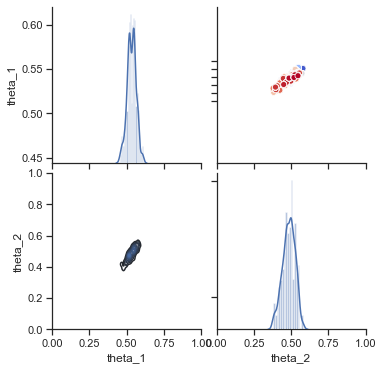

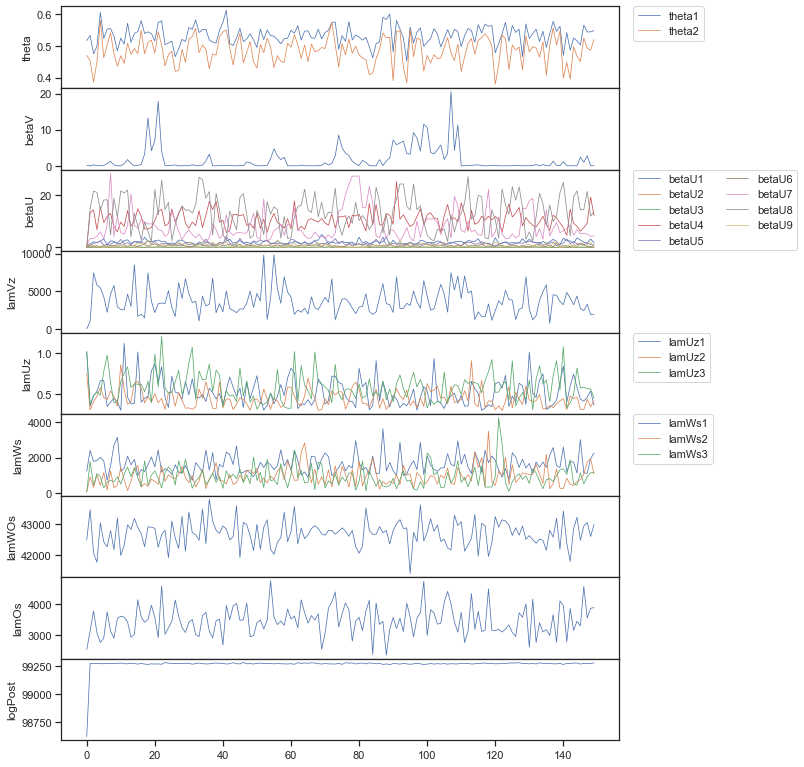

In [15]:
samples_dict2 = model2.get_samples(effectivesamples=True)
SepiaPlot.theta_pairs(samples_dict2)
SepiaPlot.mcmc_trace(samples_dict2)

# Case 3: no optimization or step size tunings

In [16]:
model3 = setup_model(data)
override=0
cachefile_name='neddermeyer_noopt_nostep.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
    model3=pickle.load(open(cachefile_name, "rb" ))
else:
    model3.do_mcmc(5000)
    pickle.dump(model3, open( cachefile_name, "w+b" ))

MCMC sampling: 100%|██████████| 5000/5000 [01:06<00:00, 75.35it/s]


Max effective sample size over thetas: 71
Total samples: 5000


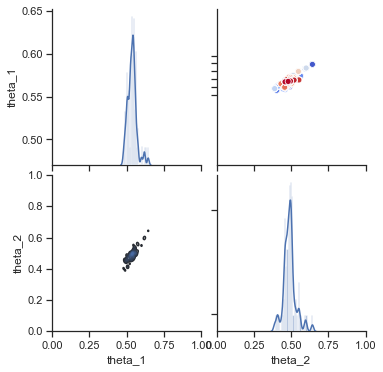

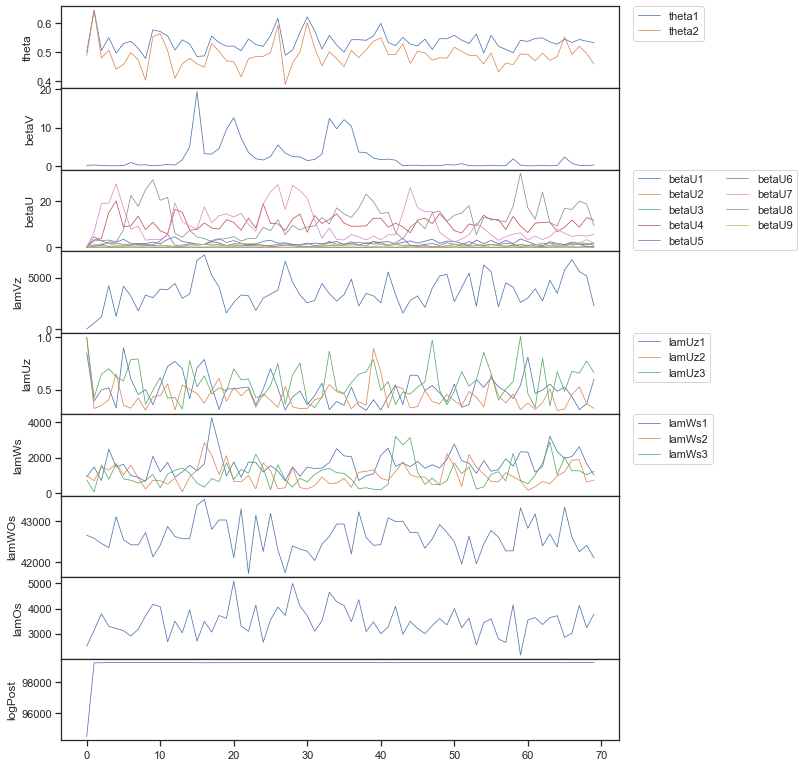

In [17]:
samples_dict3 = model3.get_samples(effectivesamples=True)
SepiaPlot.theta_pairs(samples_dict3)
SepiaPlot.mcmc_trace(samples_dict3)

# Case 4: optimization no step size tuning

In [18]:
model4 = setup_model(data)
_ = model4.optim_logPost(maxiter=10000,xatol=10,fatol=10)

optimizing logpost over all parameters
Optimization terminated successfully.
         Current function value: -98226.330572
         Iterations: 431
         Function evaluations: 728
  param  init value  opt value
  theta    0.500000   0.516561
  theta    0.500000   0.549047
  betaV    0.100000   0.104710
  betaU    0.100000   0.104961
  betaU    0.100000   0.101375
  betaU    0.100000   0.106023
  betaU    0.100000   0.114841
  betaU    0.100000   0.105135
  betaU    0.100000   0.104183
  betaU    0.100000   0.106495
  betaU    0.100000   0.109485
  betaU    0.100000   0.101024
  lamVz    2.995732   3.128401
  lamUz    1.000000   1.009870
  lamUz    1.000000   0.996316
  lamUz    1.000000   1.021615
  lamWs    6.907755   7.120175
  lamWs    6.907755   4.107871
  lamWs    6.907755   4.095226
 lamWOs   10.660909  10.656893
  lamOs    7.828503   7.921864


In [19]:
override=0
cachefile_name='neddermeyer_opt_nostep.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
    model4=pickle.load(open(cachefile_name, "rb" ))
else:
    model4.do_mcmc(5000)
    pickle.dump(model4, open( cachefile_name, "w+b" ))

MCMC sampling: 100%|██████████| 5000/5000 [01:04<00:00, 76.94it/s]


Max effective sample size over thetas: 159
Total samples: 5000


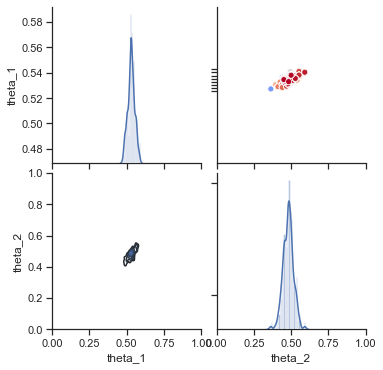

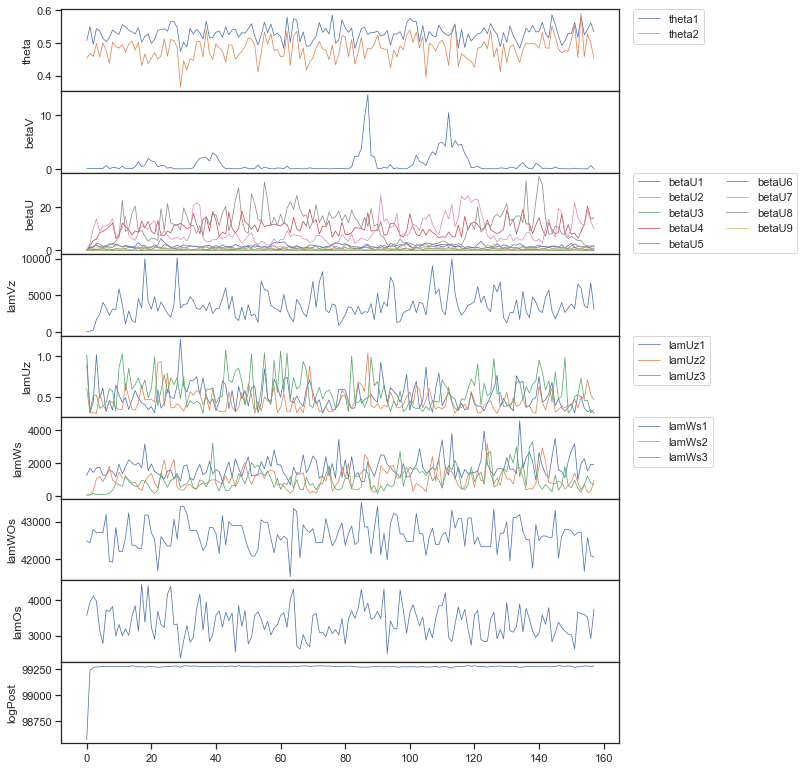

In [20]:
samples_dict4 = model4.get_samples(effectivesamples=True)
SepiaPlot.theta_pairs(samples_dict4)
SepiaPlot.mcmc_trace(samples_dict4)

# ACF

### Case 1: Step Size Tuning, No Optimization

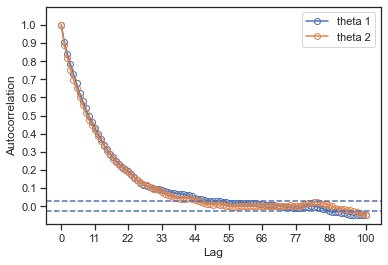

Effective Sample Sizes: [192, 205]
Total number of samples: [5000, 5000]


In [21]:
_ = SepiaPlot.plot_acf(model,nlags=100,nburn=0)

### Case 2: Optimization AND Step Size Tuning

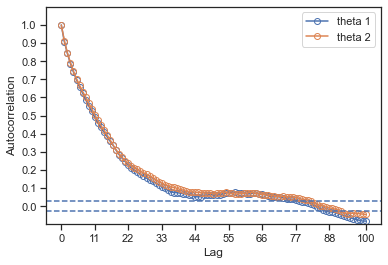

Effective Sample Sizes: [151, 144]
Total number of samples: [5000, 5000]


In [22]:
_ = SepiaPlot.plot_acf(model2,nlags=100,nburn=0)

### Case 3: No Optimization, No Step Size Tuning

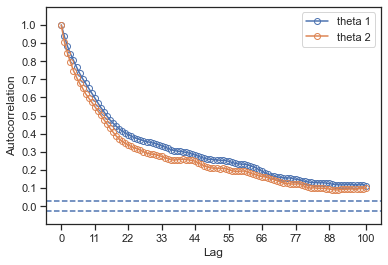

Effective Sample Sizes: [60, 71]
Total number of samples: [5000, 5000]


In [23]:
_ = SepiaPlot.plot_acf(model3,nlags=100,nburn=0)

### Case 4: Optimization, No Step Size Tuning

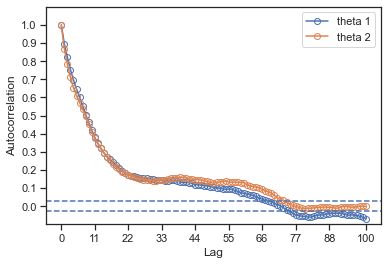

Effective Sample Sizes: [159, 144]
Total number of samples: [5000, 5000]


In [24]:
_ = SepiaPlot.plot_acf(model4,nlags=100,nburn=0)